# MNIST NNs

## Load Dataset

In [120]:
import numpy as np
import pandas as pd
import tensorflow as tf

np.set_printoptions(suppress=True)

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

# normalisation
X_train = X_train / 255
X_test = X_test / 255

def createY(y):
    Y = np.zeros(10)
    Y[y] = 1
    return Y

# reshape
X_train = X_train.reshape(60000, 28 ** 2)
X_test = X_test.reshape(10000, 28 ** 2)
y_train = np.array([createY(y) for y in y_train])
y_test =np.array([createY(y) for y in y_test])

# tensorflow
# X_train = tf.Variable(X_train, dtype=tf.float64)
# X_test = tf.Variable(X_test, dtype=tf.float64)
# y_train = tf.Variable(y_train, dtype=tf.float64)
# y_test = tf.Variable(y_test, dtype=tf.float64)

## Initialize HyperParameters

In [121]:
def inistial_parameters(n, dims):
    
    W = {}
    B = {}
    
    for i in range(len(dims)):
        dim = dims[i]
        if i == 0:
            w =  np.random.randn(n, dim) * 1e-2
            W['W' + str(i + 1)] = w
            b = np.random.randn(1) * 1e-2
            B['b' + str(i + 1)] = b
        else:
            w = np.random.randn(dims[i-1], dim) * 1e-2
            W['W' + str(i + 1)] = w
            b = np.random.randn(1) * 1e-2
            B['b' + str(i + 1)] = b
            
    return {
        'W' : W,
        'b' : B
    }

#debug
# test_n = X_train.shape[1]
# test_dims = [100, 100, 100, 200]
# test_parameters = inistial_parameters(n, dims)
# test_parameters['b']

## Linear Regression

In [122]:
def linear(X, W, b):
    return np.dot(X, W) + b

# debug
# linear(np.random.randn(4, 3), tf.Variable(np.random.randn(3, 1), dtype=tf.float32), 1)

## ReLU

In [123]:
def relu(X):
    return np.maximum(X, 0)

## Sigmoid

In [124]:
def sigmoid(X):
    return 1 / (1 + np.exp(-X))

## Softmax

In [125]:
def softmax(X):
    return (np.exp(X)) / (np.sum(np.exp(X)))

## Activation function

In [126]:
def activation(A_prev, W, b, active):
    """
    activation - sigmoid/relu/softmax
    """
    
    if active == 'sigmoid':
        Z = linear(A_prev, W, b)
        A = sigmoid(Z)
    elif active == 'relu':
        Z = linear(A_prev, W, b)
        A = relu(Z)
    elif active == 'softmax':
        Z = linear(A_prev, W, b)
        A = softmax(Z)
        
    return A, Z

## L model forward

In [196]:
def L_model_forward(X, W, b):
    A = X.copy()
    L = len(b)
    caches = {}
    
    caches['A0'] = A
    
    for i in range(1, L):
        A_prev = A
        
        A, Z = activation(A_prev, W['W' + str(i)], b['b' + str(i)], 'relu')
        caches['A' + str(i)] = A
        caches['Z' + str(i)] = Z
        
    AL, ZL = activation(A, W['W' + str(L)], b['b' + str(L)], 'softmax')
    caches['A' + str(L)] = AL
    caches['Z' + str(L)] = ZL
    
    return (AL, caches)

# debug
# test = L_model_forward(X_test, W, b)
# print(test[0])

## Cross entropy error function for softmax

In [128]:
def crossEntropyError(AL, y):
    m = AL.shape[0]
    cost = - (1 / m) * (np.sum(y * np.log(AL), axis=0, keepdims=True))
    return cost

## Softmax derivative

In [129]:
def softmax_derivative():
    pass

## ReLU derivative

In [130]:
def relu_derivative(dA):
    _dA = dA.copy()
    _dA[_dA < 0] = 0
    _dA[_dA > 0] = 1
    return _dA

## Linear derivative

$$g'(u) = g(u) .* (1 - g(u))$$

In [131]:
def linear_derivative(Z):
    g_derivative = Z * (1 - Z)
    return g_derivative

## Train Function

In [211]:
dims = [200, 200, 10]

def train_function(X_train, X_test, y_train, y_test, dims):
    
    # Initial parameters
    
    n = X_train.shape[1]
    m = X_train.shape[0]
    
    L = len(dims)
    
    parameters = inistial_parameters(n, dims)
    W = parameters['W']
    b = parameters['b']
    alpha = 1e-2
    
    costs_train = []
    costs_test = []
    current_percentage = []

    for i in range(50):
        AL, caches = L_model_forward(X_train, W, b)
        AL_test, caches_test = L_model_forward(X_test, W, b)

#       #  cross Entropy
        J_L_train = (1 / n) * np.sum(crossEntropyError(AL, y_train))
        J_L_test = (1 / n) * np.sum(crossEntropyError(AL_test, y_test))

        costs_train.append(J_L_train)
        costs_test.append(J_L_test)

#         currentNum = 0
#         for i in range(0, len(y_test)):
#             if np.argmax(y_test[i]) - np.argmax(AL_test[i]) == 0:
#                 currentNum += 1
                
#         current_percentage.append(currentNum / len(y_test))

        softmax_derivative = AL - y_train

        dW_L = (1 / m) * np.dot(caches['A' + str(L - 1)].T, softmax_derivative) 
        
        db_L = (1 / n) * np.sum(softmax_derivative)
        
        dZ_next = softmax_derivative
        
        temp_dW = {}
        temp_db = {}
        
        temp_dW['W' + str(L)] = W['W' + str(L)] - alpha * dW_L
        temp_db['b' + str(L)] = b['b' + str(L)] - alpha * db_L
        
        
        for dimI in range(L-1, 0, -1):
            
            _relu_derivative = relu_derivative(caches['Z' + str(dimI)])

            dZ_1 = np.dot(dZ_next, W['W' + str(dimI + 1)].T) * _relu_derivative
            
            dZ_next = dZ_1

            dW_1 = (1 / m) * np.dot(caches['A' + str(dimI - 1)].T, dZ_1)

            db_1 = (1 / m) * np.sum(dZ_1)

            temp_dW['W' + str(dimI)] = W['W' + str(dimI)] - alpha * dW_1
            temp_db['b' + str(dimI)] = b['b' + str(dimI)] - alpha * db_1
            
        for tempi in range(1, L + 1):
            W['W' + str(tempi)] = temp_dW['W' + str(tempi)]
            b['b' + str(tempi)] = temp_db['b' + str(tempi)]
        
       
        
    return costs_train, costs_test, current_percentage, W, b

In [212]:
train_m = 5000
test_m = 500
costs_train, costs_test, current_percentage, W, b = train_function(X_train[:train_m], X_test[:test_m], y_train[:train_m], y_test[:test_m], dims)

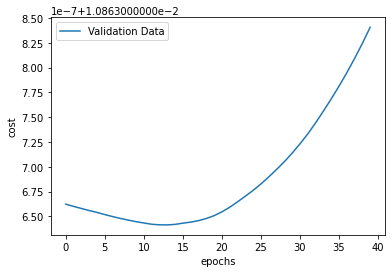

In [216]:
import matplotlib.pyplot as plt

# plt.plot(costs_train[10:], label="Train Data")
plt.plot(costs_test[10:], label="Validation Data")
# print(np.max(current_percentage))
# plt.plot(current_percentage[:], label="Current Test")
plt.ylabel('cost')
plt.xlabel('epochs')
plt.legend()
plt.show()



[0.0996166  0.09897231 0.09990507 0.09987481 0.09970297 0.09983781
 0.09970533 0.1011025  0.1007705  0.1005121 ]
7


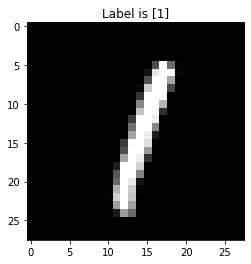

In [214]:
## Test

index = 5


single_label = np.where(y_test[index] == 1)[0]

single_Image = X_test[index]
single_Image_r = single_Image.reshape((28, 28))

test, _ = L_model_forward(single_Image, W, b)
# print(test - )

print(test)
print(np.argmax(test))

plt.title('Label is {label}'.format(label=single_label))
plt.imshow(single_Image_r, cmap='gray')
plt.show()

# 